In [1]:
!pip install matplotlib

In [2]:
import glob
import h5py
import matplotlib.pyplot as plt
import numpy as np
import tifffile
from matplotlib.patches import Ellipse

In [3]:
out_dir = "/scratch/minDistance0"

In [14]:
for exp_id in range(1,13):
        GT = h5py.File(glob.glob(f"{out_dir}/{exp_id}/*groundtruth.h5")[0])["GT"]
        print(np.mean(GT["Z"][:]))

1.3113389251499399
2.6313749134125617
1.516103757982873
1.8004780579036663
2.06570338674968
2.016762785352123
2.139469275365826
1.8856131935193612
2.1432516785806235
2.0081344173314313
1.4987876053064135
1.5425343796907345


2.460777699722404
2.4738933239738703
2.4906414244853092
2.470096975619205
2.453706181963083
2.4475028116445268
2.2915859857978917
2.494505182190837
2.395292398443541
2.4934052208227477
2.4894142604136063
2.3216719344295687
2.460777699722404
2.4738933239738703
2.4906414244853092
2.470096975619205
2.453706181963083
2.4475028116445268
2.2915859857978917
2.494505182190837
2.395292398443541
2.4934052208227477
2.4894142604136063
2.3216719344295687


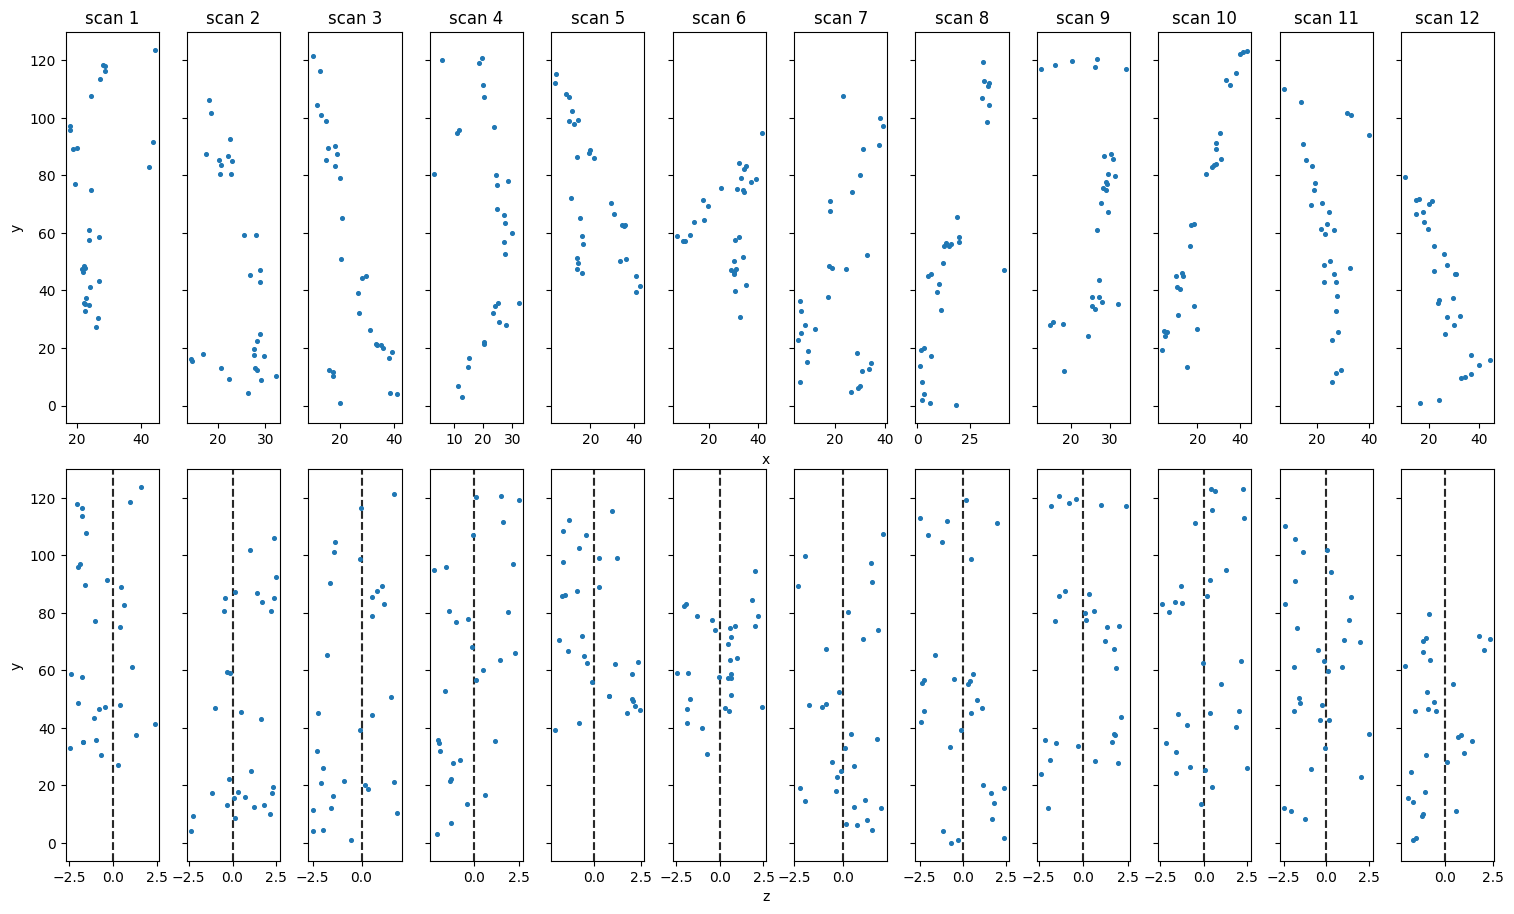

In [4]:
fig, ax = plt.subplots(2,12,figsize=(15,9), sharey=True)
for r, proj in enumerate(("xy", "zy")):
    for exp_id in range(1,13):
        GT = h5py.File(glob.glob(f"{out_dir}/{exp_id}/*groundtruth.h5")[0])["GT"]
        mus = np.transpose([GT['R'][:] if proj=="xy" else GT['Z'][:]-2, GT['C'][:]])
        ax[r, exp_id-1].scatter(mus[:,0], mus[:,1], s=7)
        ax[1, exp_id-1].axvline(ls="--", c="k", alpha=.6, zorder=-1)
        ax[0, exp_id-1].set_title(f"scan {exp_id}")
        print(max(abs(GT["Z"][:]-2)))
    ax[r, 5].set_xlabel(proj[0], x=1)
    ax[r, 0].set_ylabel("y")
plt.tight_layout(pad=.2)
plt.savefig(f"{out_dir}/centers_proj", dpi=200, bbox_inches="tight", pad_inches=0.03)

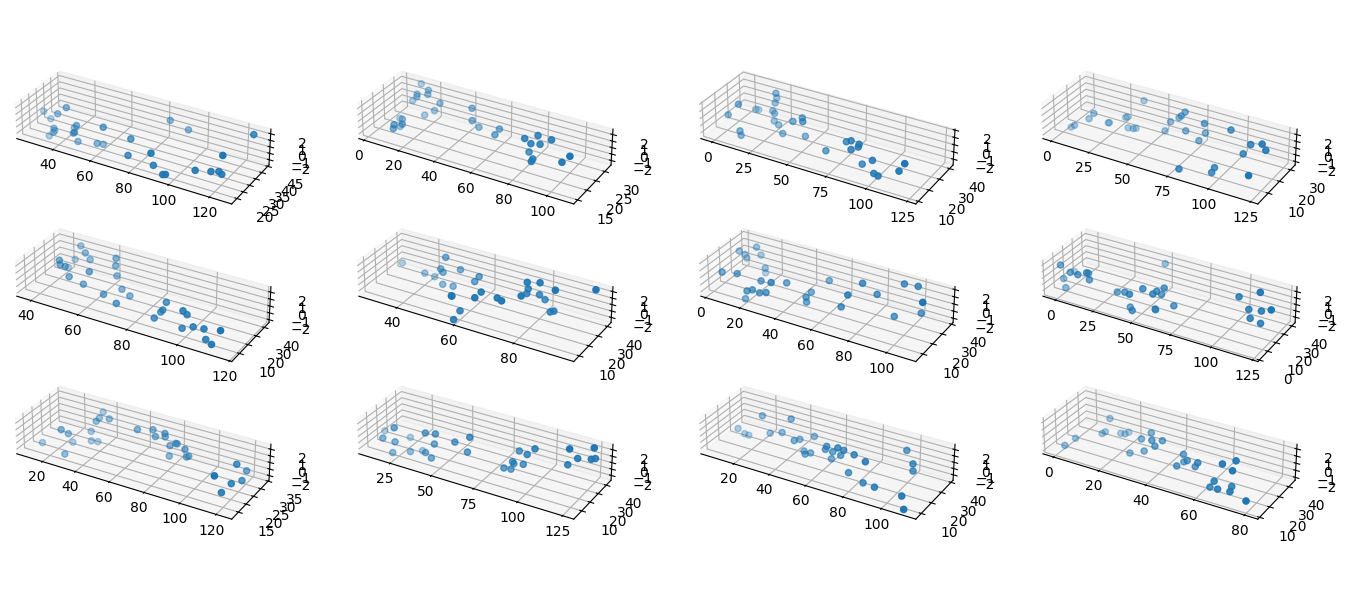

In [5]:
fig = plt.figure(figsize=(15,6))
for exp_id in range(1,13):
    ax = fig.add_subplot(3,4,exp_id, projection='3d', facecolor='none')
    GT = h5py.File(
            glob.glob(f"/{out_dir}/{exp_id}/*groundtruth.h5")[0]
        )["GT"]
    ax.scatter(GT['C'][:], GT['R'][:], GT['Z'][:]-2)
    ax.set_box_aspect((12, 4, 2))
plt.tight_layout(h_pad=-7)

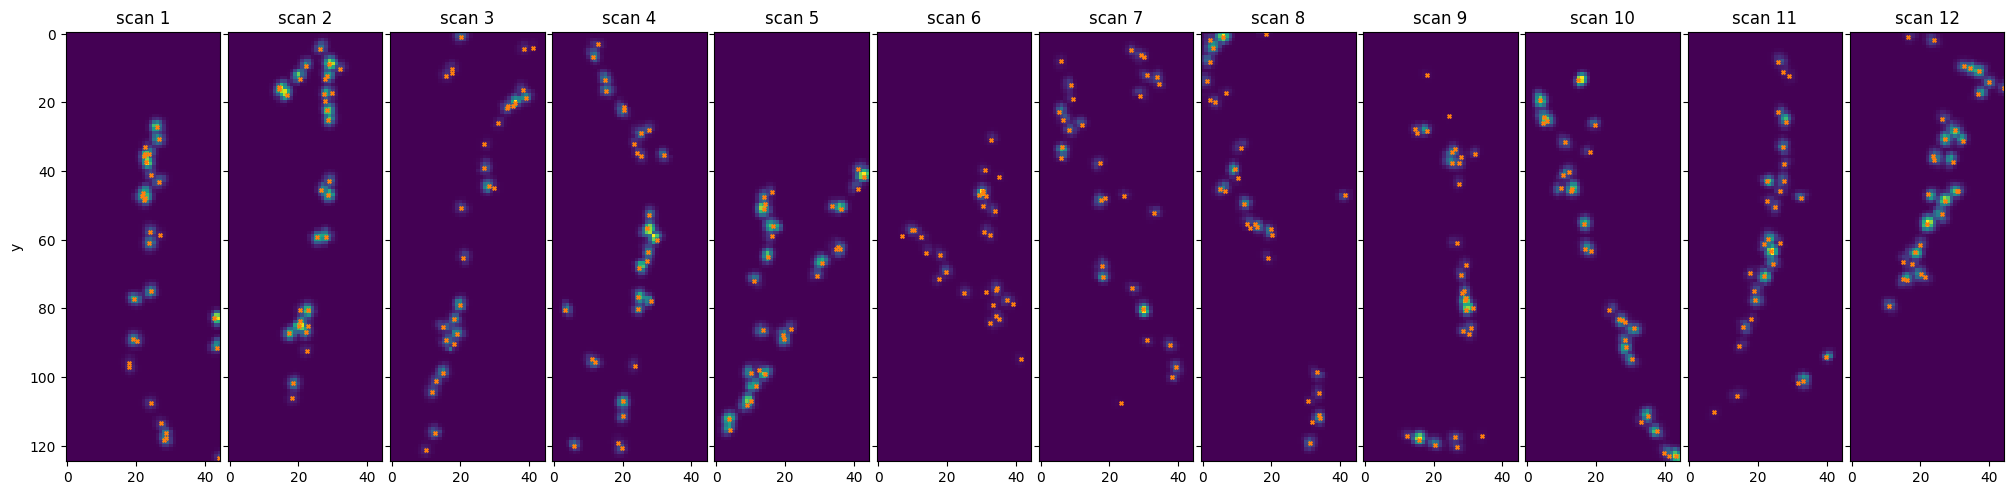

In [6]:
fig, ax = plt.subplots(1,12, figsize=(20,6), sharey=True)
for exp_id in range(1,13):
    GT = h5py.File(
        glob.glob(f"/{out_dir}/{exp_id}/*groundtruth.h5")[0]
    )["GT"]
    mus = np.transpose([GT['R'][:], GT['C'][:]])
    ax[exp_id-1].imshow(GT['ROIs'][2].max(-1).T)
    ax[exp_id-1].scatter(mus[:,0], mus[:,1], marker="x", s=7, c='C1')
    ax[exp_id-1].set_title(f"scan {exp_id}")
ax[0].set_ylabel("y")
plt.tight_layout(pad=.2)

In [7]:
def plot_ellipsoid(ax, mu, sigma_x, sigma_y, sigma_z, color="blue", alpha=0.3):
    # Parametric sphere
    phi, theta = np.mgrid[0:np.pi:30j, 0:2*np.pi:30j]
    
    # Scale to ellipsoid
    X = sigma_x * np.sin(phi) * np.cos(theta) + mu[0]
    Y = sigma_y * np.sin(phi) * np.sin(theta) + mu[1]
    Z = sigma_z * np.cos(phi) + mu[2]
    
    ax.plot_surface(X, Y, Z, color=color, alpha=alpha, linewidth=0)

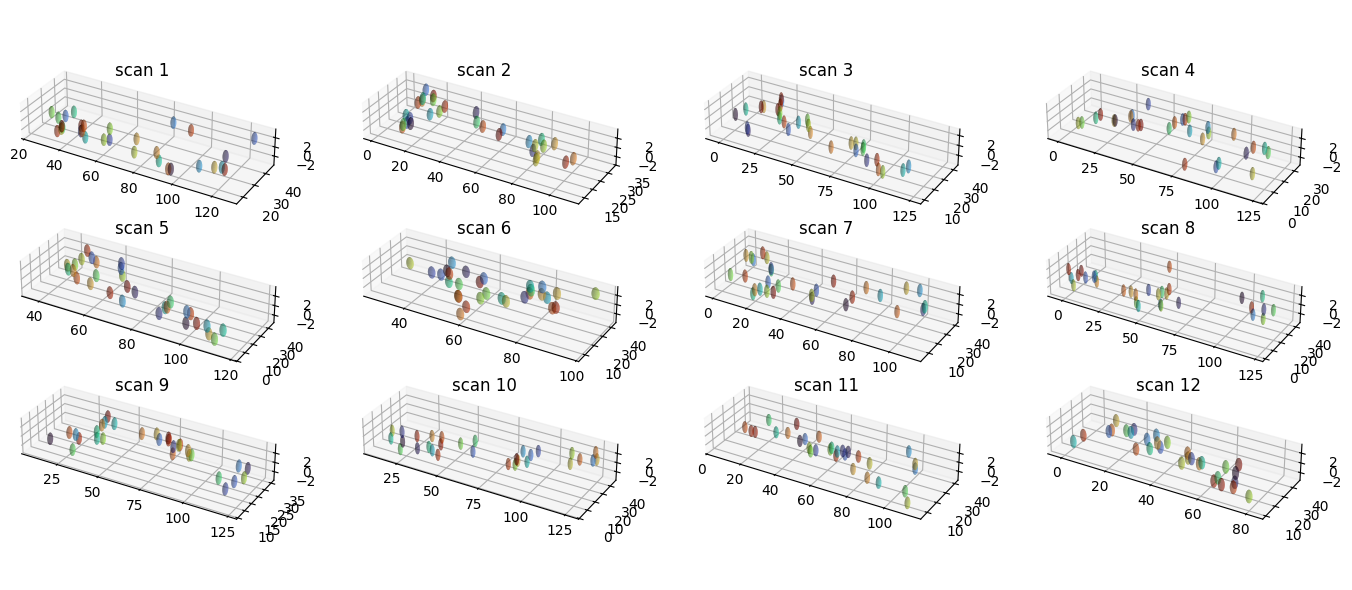

In [8]:
sigma = 1.33

fig = plt.figure(figsize=(15,6))
for exp_id in range(1,13):
    ax = fig.add_subplot(3,4,exp_id, projection='3d', facecolor='none')
    GT = h5py.File(
            glob.glob(f"/{out_dir}/{exp_id}/*groundtruth.h5")[0]
        )["GT"]
    mus = np.transpose([GT['C'][:], GT['R'][:], GT['Z'][:]-2])
    for i, mu in enumerate(mus):
        # use a colormap for nicer visualization
        color = plt.cm.turbo(i / len(mus))  # punchy palette
        plot_ellipsoid(ax, mu, sigma, sigma, sigma, color=color, alpha=0.4)
    ax.set_title(f"scan {exp_id}", y=.77)
    ax.set_box_aspect((12, 4, 2))
plt.tight_layout(h_pad=-7)
plt.savefig(f"/{out_dir}/ellipsoids.png", dpi=200, bbox_inches="tight", pad_inches=0.03)

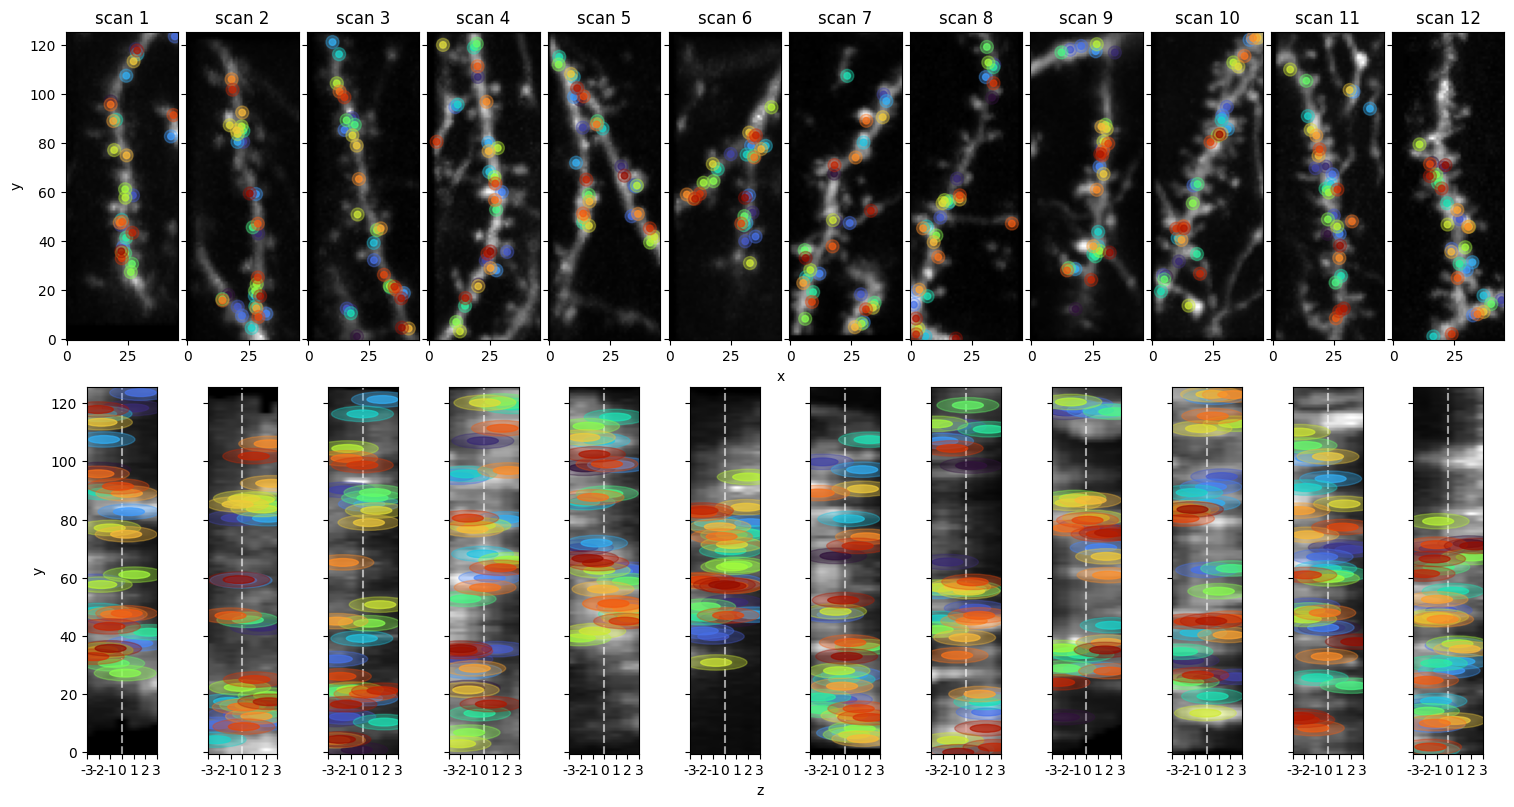

In [9]:
sigma = 1.33

fig, ax = plt.subplots(2,12,figsize=(15,8), sharey=True)
for r, proj in enumerate(("xy", "zy")):
    for exp_id in range(1,13):
        mov = tifffile.imread(f"/data/zstacks/scan_000{exp_id:02}-REF_Ch2.ome.tif")
        mid = (mov.shape[0]+1)//2
        ax[r, exp_id-1].imshow(np.log(1+.005*mov[mid-3:mid+4].max(r).T), cmap="gray", aspect=1/(1+3*r), zorder=-2)
        if r:
            ax[1, exp_id-1].axvline(3, ls="--", c="white", alpha=.6, zorder=-1)
            ax[1, exp_id-1].set_xticks(range(7), range(-3,4))
        GT = h5py.File(
            glob.glob(f"/{out_dir}/{exp_id}/*groundtruth.h5")[0]
        )["GT"]
        mus = np.transpose([GT['R'][:] if proj=="xy" else GT['Z'][:]+1, GT['C'][:]])
        for i, mu in enumerate(mus):
            color = plt.cm.turbo(i / len(mus))
            for z in (1,2):
                ell = Ellipse(xy=(mu[0], mu[1]), 
                              width=2*sigma*z, height=2*sigma*z,  # diameter = 2σ
                              edgecolor=color, facecolor=color, lw=1, alpha=.7/z)
                ax[r, exp_id-1].add_patch(ell)
        # ax[r, exp_id-1].scatter(mus[:,0], mus[:,1], s=1, c="k")
        ax[r, exp_id-1].set_xlim((-.5, 0)[r], (45.5, 6)[r])
        ax[r, exp_id-1].set_ylim(-.5, 125.5)
        ax[0, exp_id-1].set_title(f"scan {exp_id}")
    ax[r, 5].set_xlabel(proj[0], x=1)
    ax[r, 0].set_ylabel("y")
plt.tight_layout(pad=.2)
plt.savefig(f"/{out_dir}/ellipsoids_proj", dpi=200, bbox_inches="tight", pad_inches=0.03)

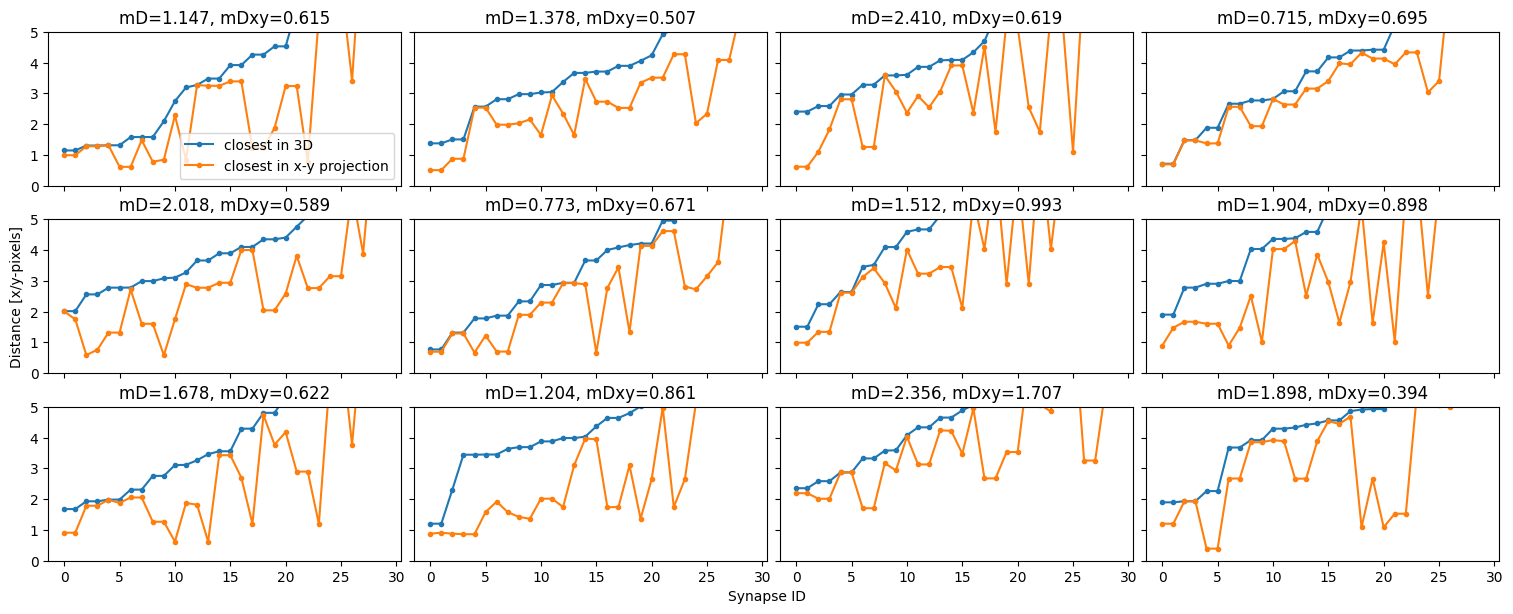

In [10]:
def dist(x, y=np.zeros(3)):
    d = x - y
    d[0] *= 2  # pixel size along z is 2x larger than x/y
    return np.linalg.norm(d)
 
fig, ax = plt.subplots(3,4, figsize=(15,6), sharex=True, sharey=True)
ax = ax.flatten()
for exp_id in range(1,13):
    a = ax[exp_id-1]
    GT = h5py.File(
            glob.glob(f"/{out_dir}/{exp_id}/*groundtruth.h5")[0]
        )["GT"]
    centers = np.transpose([GT["Z"][:], GT["R"][:], GT["C"][:]])
    d = np.array([[dist(c1, c2) for c1 in centers] for c2 in centers])
    dxy = np.array([[np.linalg.norm(c1[1:]-c2[1:]) for c1 in centers] for c2 in centers])
    closest = np.array([float(min(dd[dd>0])) for dd in d])
    order = np.argsort(closest)
    # print(np.sort(closest))
    a.plot(closest[order], ".-", label="closest in 3D")
    closest_xy = np.array([float(min(dd[dd>0])) for dd in dxy])
    a.plot(closest_xy[order], ".-", label="closest in x-y projection")
    if exp_id==1:
        a.legend()
    elif exp_id==5:
        a.set_ylabel("Distance [x/y-pixels]")
    elif exp_id==10:
        a.set_xlabel("Synapse ID", x=1)
    a.set_ylim(0, 5)
    a.set_title(f"mD={min(closest):.3f}, mDxy={min(closest_xy):.3f}")
plt.tight_layout(pad=.2)